In [87]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf

## Utilities

In [88]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Pre

In [89]:
data_folder = "data"
filename = "train.csv"
df = pd.read_csv(os.path.join("..", data_folder, filename), parse_dates=True, index_col="date")

In [90]:
df_subset = df[["warehouse", "orders"]]
df_subset.head()

,warehouse,orders
date,,
2020-12-05,Prague_1,6895.0
2020-12-06,Prague_1,6584.0
2020-12-07,Prague_1,7030.0
2020-12-08,Prague_1,6550.0
2020-12-09,Prague_1,6910.0


In [91]:
Prague_1_df = df_subset[df_subset["warehouse"] == "Prague_1"].drop(columns=["warehouse"])
Prague_1_df.shape

(1193, 1)

In [92]:
# Convert to numpy arrays

time_steps = np.array(range(len(Prague_1_df)))
series = Prague_1_df["orders"].values

In [93]:
series.shape

(1193,)

## Split the Dataset

In [94]:
# Take the last year as validation set
split_time = len(Prague_1_df) - 365

# Get the train set
time_train = time_steps[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time_steps[split_time:]
x_valid = series[split_time:]

In [95]:
x_valid.shape

(365,)

## Prepare Features and Labels

In [96]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [97]:
# Parameters
window_size = 365
batch_size = 36
shuffle_buffer_size = 100

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Building the model

In [98]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

 # Print the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 365, 64)           256       
                                                                 
 lstm_10 (LSTM)              (None, 365, 64)           33024     
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dense_9 (Dense)             (None, 30)                1950      
                                                                 
 dense_10 (Dense)            (None, 10)                310       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 68,575
Trainable params: 68,575
Non-trai

In [99]:
# Set the learning rate
learning_rate = 0.001

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

In [100]:
# Train the model
history = model.fit(train_set, epochs=15)

Epoch 1/15
13/13 [==============================] - 13s 599ms/step - loss: 8634.7236 - mean_absolute_percentage_error: 99.9898
Epoch 2/15
13/13 [==============================] - 7s 572ms/step - loss: 8632.8896 - mean_absolute_percentage_error: 99.9683
Epoch 3/15
13/13 [==============================] - 8s 584ms/step - loss: 8624.7188 - mean_absolute_percentage_error: 99.8726
Epoch 4/15
13/13 [==============================] - 8s 595ms/step - loss: 8549.3809 - mean_absolute_percentage_error: 98.9969
Epoch 5/15
13/13 [==============================] - 8s 585ms/step - loss: 5070.1548 - mean_absolute_percentage_error: 59.1791
Epoch 6/15
13/13 [==============================] - 7s 536ms/step - loss: 2969.8301 - mean_absolute_percentage_error: 34.7084
Epoch 7/15
13/13 [==============================] - 7s 546ms/step - loss: 1983.2273 - mean_absolute_percentage_error: 22.8981
Epoch 8/15
13/13 [==============================] - 8s 594ms/step - loss: 1397.6443 - mean_absolute_percentage_error:

## Model Prediction

In [101]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

11/11 [==============================] - 3s 183ms/step


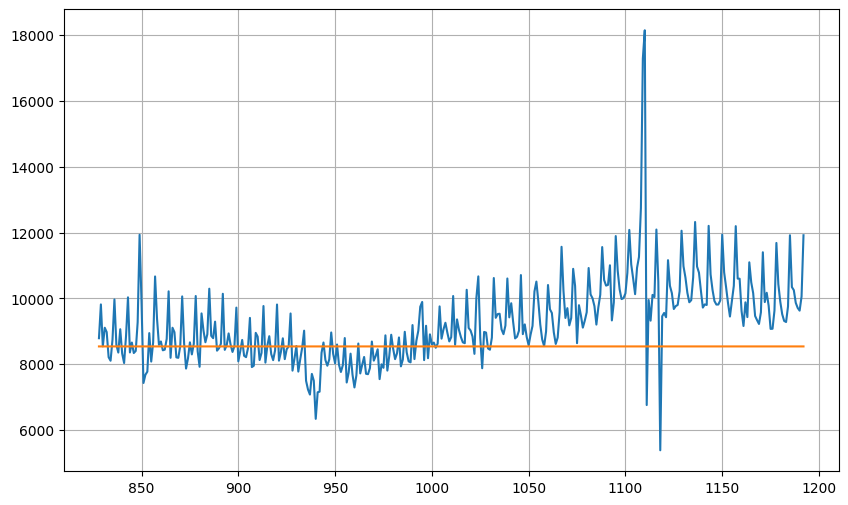

In [102]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [103]:
from sklearn.metrics import mean_absolute_percentage_error

In [104]:
print(x_valid.shape)
print(results.shape)

# Compute the MAPE
print(mean_absolute_percentage_error(x_valid, results) * 100)

(365,)
(365,)
10.181766138378661
